<div style="float:left;font-size:20px;">
    <h1>Moon shot</h1>
</div><div style="float:right;"><img src="../assets/banner.jpg"></div>

_Problem:_ Simulating a satellite orbit of the moon.

Project problem in 2D.

$\underline{F} = -\frac{GmM}{r^{2}}\underline{\hat{r}}$

<hr>

In [1]:
import matplotlib.pyplot as plt
from matplotlib import ticker, cm
from matplotlib.patches import Circle
from matplotlib.patheffects import withStroke
import numpy as np
from scipy.integrate import RK45

In [2]:
class Body(object):
    
    def __init__(self, x=None, v=np.zeros(2), a=np.zeros(2), mass=0, radius=None, color=None):
        self.x = x
        self.v = v
        self.a = a
        self.mass = mass
        self.radius = radius
        self.color = color
    
    def draw(self):
        circle = Circle((self.x[0], self.x[1]), self.radius, clip_on=False, zorder=10, linewidth=0, edgecolor='black', facecolor=self.color)
        ax = plt.gca()
        ax.add_artist(circle)

In [3]:
# Simulation configuration, all units are SI
m_earth = 5.972e24
m_moon = 7.348e22
r_earth = 6.371e6
r_moon = 1.737e6
m_satellite = 1
G = 6.67e-11

# Position vectors (x, y)
x_earth = np.array([0, 0])
x_moon = np.array([3.85e8, 0])

earth = Body(x=x_earth, mass=m_earth, radius=r_earth, color=(0.1, 0.1, 0.8, .8))
moon = Body(x=x_moon, mass=m_moon, radius=r_moon, color=(0.7, 0.7, 0.7, .8))

In [4]:
def f_grav(m1, m2, x1, x2, r_limit=None):
    """Compute the gravitational force between two bodies.
    
    Returns gravitational vector exerted on body 1.
    
    mass - m
    position - r
    """
    delta_x = (x2 - x1)
    norm_x = np.linalg.norm(delta_x)
    if r_limit:
        if norm_x < r_limit:
            delta_x = delta_x/norm_x*r_limit
            norm_x = r_limit # Still need to fix delta_x
    r3 = norm_x*norm_x*norm_x
    return -G*m1*m2/r3*delta_x

In [5]:
# Verification - orbital velocity of moon is ~1km/s
np.sqrt(np.linalg.norm(f_grav(earth.mass, moon.mass, earth.x, moon.x))*3.85e8/moon.mass)

1017.1674446174585

In [6]:
# Verification - g ~ 9.81 m/s^2
np.linalg.norm(f_grav(earth.mass, 1, earth.x, [earth.radius, 0]))

9.813646787366263

In [7]:
# Performance
%timeit f_grav(earth.mass, moon.mass, earth.x, moon.x)

10.4 µs ± 30.4 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


## Visualise the problem

- Visual of bodies, gravitational forces and equipotentials
- Contours of graviational force are equipotentials, gradient of these are the force vectors

In [8]:
def compute_grid(x, y):
    return np.meshgrid(x, y, sparse=False, indexing='ij')
    
def compute_force_grid(xx, yy, body):
    """Calculate gravitation force in a grid"""
    xs = [np.array([x_i, y_i]) for x_i, y_i in zip(np.ravel(xx), np.ravel(yy))]
    #f_body = f_grav(body.mass, 1, body.x, xs)
    f_body = np.array([f_grav(body.mass, 1, body.x, xi, r_limit=body.radius) for xi in xs])
    f_body_mag = np.array([np.linalg.norm(force) for force in f_body]).reshape(xx.shape)
    return f_body, f_body_mag

In [9]:
def plot_force_grid(xx, yy, f_body_mag, bodies=None, fill=False, log=True, n_contours=20, f_min=None, f_max=None):
    """Plot the force isocontours across the grid range"""
    f_min = f_min if f_min else f_body_mag.min()
    f_max = f_max if f_max else f_body_mag.max()
    if log:
        log_min = np.floor(np.log10(f_min))
        log_max = np.ceil(np.log10(f_max))
        levels = np.logspace(log_min, log_max, n_contours)
    else:
        f_min = f_min if f_min else np.floor(f_min)
        f_max = f_max if f_max else np.ceil(f_max)
        levels = np.linspace(f_min, f_max, n_contours)
            
    if fill:
        contours = ax.contourf(xx, yy, f_earth_mag, 10, locator=ticker.LogLocator(), cmap='RdGy')
        cbar = fig.colorbar(contours)
    else:
        contours = ax.contour(xx, yy, f_body_mag, levels=levels, cmap='RdGy') #, fmt='%.2E')
        plt.clabel(contours, inline=True, fontsize=8)
    
    if bodies:
        for body in bodies:
            body.draw()

    plt.xlabel('x (m)')
    plt.ylabel('y (m)')

In [10]:
# Setup grids: system, earth and moon
grid_system = [np.linspace(0, 5e8, 100), np.linspace(-2.5e8, 2.5e8, 100)]
grid_earth = [np.linspace(earth.x[0] - 2*earth.radius, earth.x[0] + 2*earth.radius, 100), 
              np.linspace(earth.x[1] - 2*earth.radius, earth.x[1] + 2*earth.radius, 100)]
grid_moon = [np.linspace(moon.x[0] - 2*moon.radius, moon.x[0] + 2*moon.radius, 100), 
             np.linspace(moon.x[1] - 2*moon.radius, moon.x[1] + 2*moon.radius, 100)]

xx_system, yy_system = np.meshgrid(grid_system[0], grid_system[1], sparse=False, indexing='ij')
xx_earth, yy_earth = np.meshgrid(grid_earth[0], grid_earth[1], sparse=False, indexing='ij')
xx_moon, yy_moon = np.meshgrid(grid_moon[0], grid_moon[1], sparse=False, indexing='ij')

### Earth

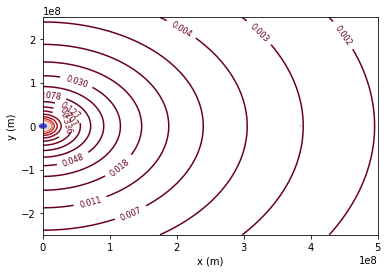

In [11]:
# Force of gravity from Earth
f_earth, f_earth_mag = compute_force_grid(xx_system, yy_system, earth)
fig, ax = plt.subplots()
plot_force_grid(xx_system, yy_system, f_earth_mag, [earth, moon], n_contours=20, f_max=9.81)

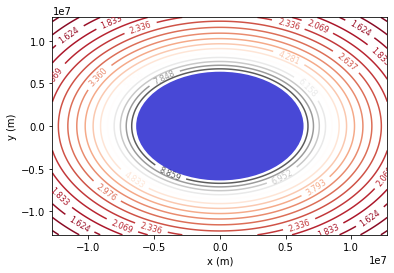

In [12]:
f_earth_local, f_earth_local_mag = compute_force_grid(xx_earth, yy_earth, earth)
fig, ax = plt.subplots()
plot_force_grid(xx_earth, yy_earth, f_earth_local_mag, [earth], fill=False, f_max=9.81)

### Moon

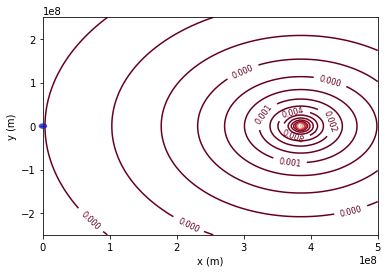

In [13]:
f_moon, f_moon_mag = compute_force_grid(xx_system, yy_system, moon)
fig, ax = plt.subplots()
plot_force_grid(xx_system, yy_system, f_moon_mag, [earth, moon], n_contours=20)

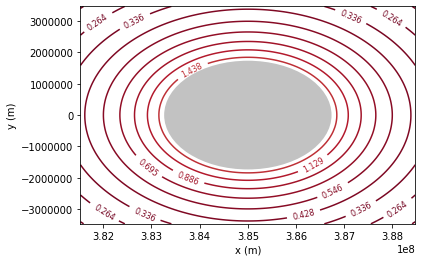

In [14]:
f_moon_local, f_moon_local_mag = compute_force_grid(xx_moon, yy_moon, moon)
fig, ax = plt.subplots()
plot_force_grid(xx_moon, yy_moon, f_moon_local_mag, [moon])

### System

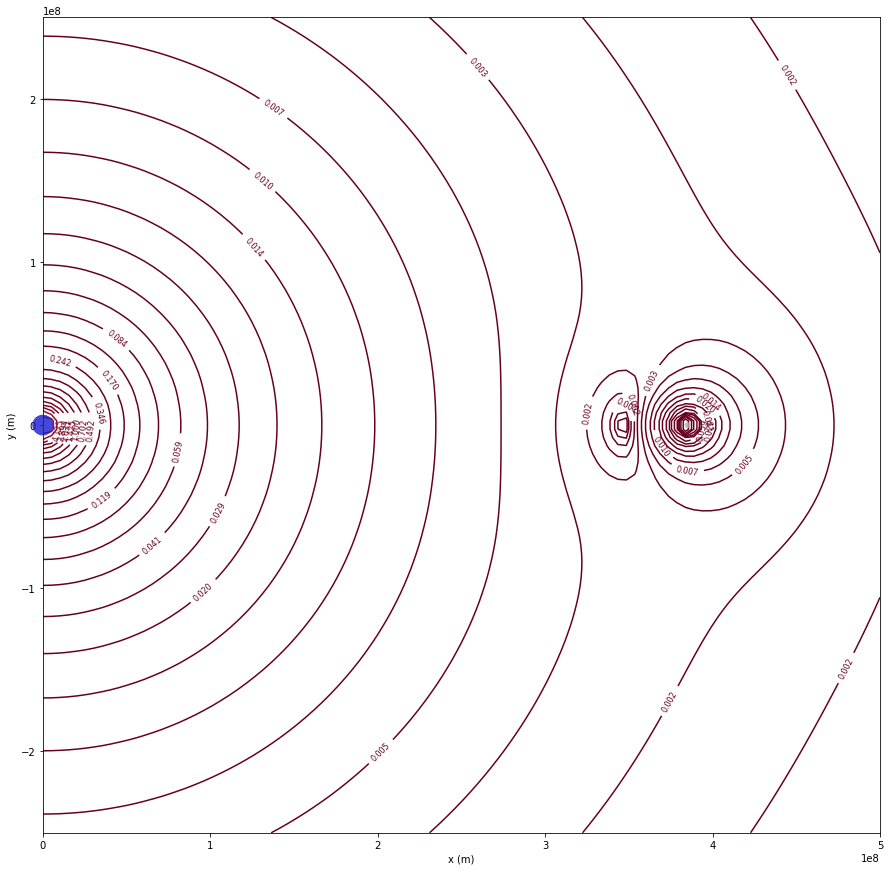

In [15]:
# Force of system - still dominated by the Earth
#f_earth, f_earth_mag = compute_force_grid(grid_system[0], grid_system[1], earth)
f_system = f_earth + f_moon
f_system_mag = np.array([np.linalg.norm(force) for force in f_system]).reshape(xx_system.shape)

fig, ax = plt.subplots(figsize=(15,15))
plot_force_grid(xx_system, yy_system, f_system_mag, [earth, moon], n_contours=40, f_max=19.81)

In [16]:
from sklearn.preprocessing import normalize
f_system_normed = normalize(f_system, norm="l1")

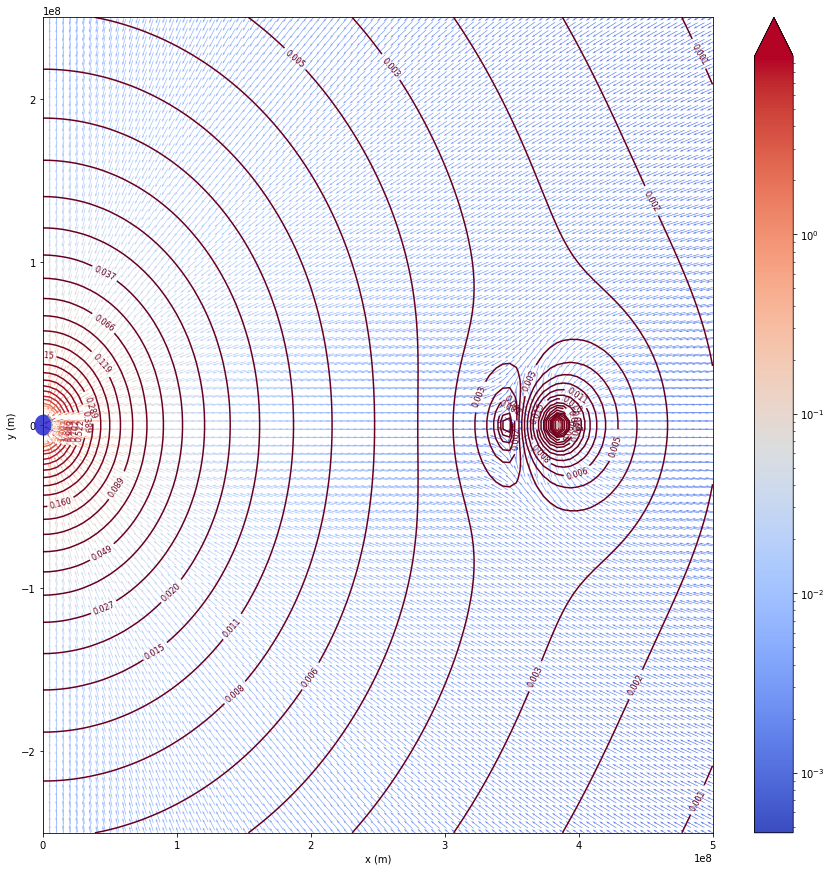

In [17]:
import matplotlib.colors as colors
fig, ax = plt.subplots(figsize=(15,15))
cap = 1

plot_force_grid(xx_system, yy_system, f_system_mag, [earth, moon], n_contours=40, f_max=9.81)
#plt.contour(xx_system, yy_system, np.log10(f_system_mag), cmap="autumn", contours=40)
Q = plt.quiver(xx_system.ravel(), yy_system.ravel(), f_system_normed[:, 0], f_system_normed[:, 1], f_system_mag,
           pivot='mid', scale=40, width=0.001, 
           cmap='coolwarm', norm=colors.LogNorm(vmin=f_system_mag.min(),vmax=f_system_mag.max()));
fig.colorbar(Q,extend='max')

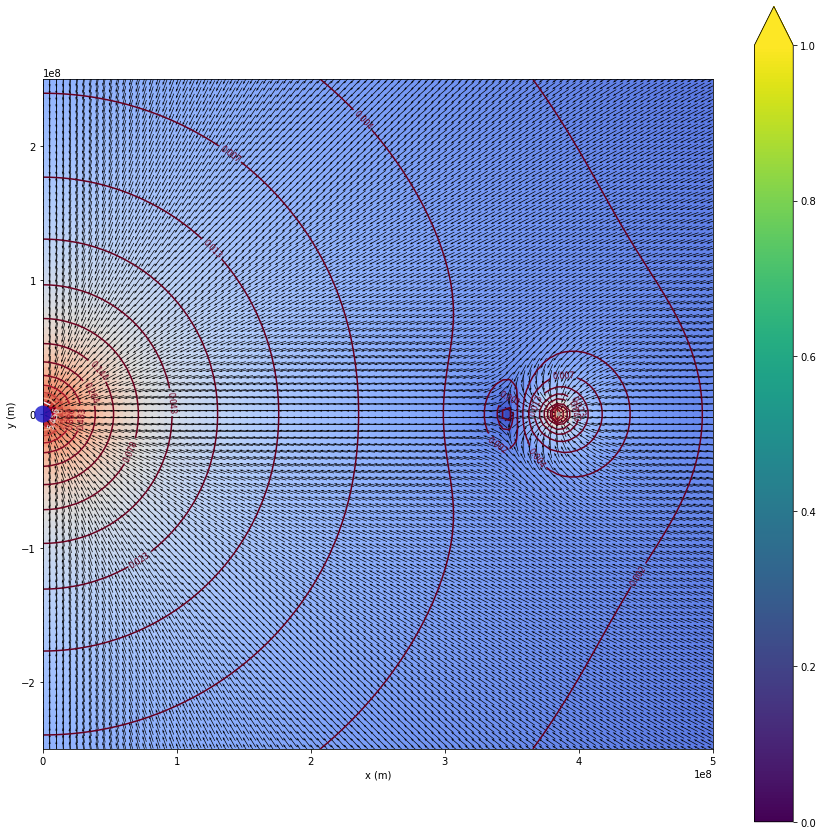

In [18]:
import matplotlib.colors as colors
fig, ax = plt.subplots(figsize=(15,15))
cap = 1
f_system_normed = normalize(f_system, norm="l1")
X = [(xx_system.ravel()[i], yy_system.ravel()[i], z) for i, z in enumerate(f_system_mag.ravel())]

plot_force_grid(xx_system, yy_system, f_system_mag, [earth, moon], n_contours=20, f_max=9.81)
Q = plt.quiver(xx_system.ravel(), yy_system.ravel(), f_system_normed[:, 0], f_system_normed[:, 1], #f_system_mag,
           pivot='mid', scale=40, width=0.001, color='black'
               #cmap='coolwarm', norm=colors.LogNorm(vmin=f_system_mag.min(),vmax=f_system_mag.max())
              ); #, [C], **kw)
I = plt.imshow(f_system_mag.T, extent=[np.min(xx_system),np.max(xx_system),np.min(yy_system),np.max(yy_system)],cmap='coolwarm',
           norm=colors.LogNorm(vmin=f_system_mag.min(),vmax=f_system_mag.max()))
fig.colorbar(Q,extend='max');

# Simulation

- https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.RK45.html


In [19]:
from  scipy.integrate import RK45

In [20]:
# t is a scalar, y is an ndarray
# Relative and absolute tolerances. The solver keeps the local error estimates less than atol + rtol * abs(y)
# vectorized: Whether fun is implemented in a vectorized fashion. Default is False.
#fun(t, y)


In [21]:
def fun(t, y): #, vectorized=True):
    return t*y


### IVP

In [22]:
from scipy.integrate import solve_ivp
# y[0] = Displacement
# y[1] = Velocity

t = [0, 100]  # Time range
y = [0, 10]  # Initialial displacement = 0, velocity = +10

def upward_cannon(t, y): 
    return [y[0] + y[1], y[1]-0.4]
def hit_ground(t, y): 
    return y[0]
def apex(t, y): return y[1]

#hit_ground.terminal = True  # Tells simulation to end if event occurs
hit_ground.direction = -1
sol = solve_ivp(upward_cannon, t, y, events=(hit_ground, apex), dense_output=True)


### Sky dive example

In [23]:
# Simulate sky dive with air resistance
g = 10
k = 0.01

def para(t,Y):
    y1 = Y[0]
    y2 = Y[1]
    dy1_dt = y2
    dy2_dt = -g + k*y2**2
    return [dy1_dt, dy2_dt]

import numpy as np
tend = 40
time = np.linspace(0,tend,100)
tspan = (0, tend)

Y0 = [1000,0]

from scipy.integrate import solve_ivp
hit_ground.terminal = True
sol = solve_ivp(para,tspan,Y0,events=hit_ground,t_eval=time)

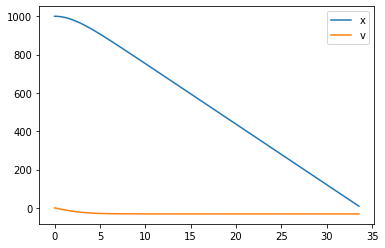

In [24]:
plt.plot(sol.t, sol.y.T)
plt.legend(['x', 'v'])

### Orbit example

In [25]:
np.linalg.norm(np.array([100,2]))

100.0199980003999

In [26]:
def kinetic_energy(v_body, mass_body=1):
    return mass_body*(0.5 * np.linalg.norm(v_body)**2)

def potential_energy(x_body, mass_body=1):
    return -mass_body * G * earth.mass/np.linalg.norm(earth.x - x_body)

def total_energy(x_body, v_body, mass_body=1):
    return kinetic_energy(v_body, mass_body=mass_body) + potential_energy(x_body, mass_body=mass_body)

In [27]:
# Orbital velocity at Earth's surface
v_orbital = np.sqrt(G * earth.mass / (2 * earth.radius))
v_orbital

5591.186979627424

In [28]:
# Simulate gravitational orbit
def orbit(t, Y):
    """Y vector = (x, y, v_x, v_y)"""
    x = np.array(Y[:2])
    v = np.array(Y[2:])
    a = f_grav(earth.mass, 1, earth.x, x, r_limit=earth.radius)
   
    # Update displacements with velocity of last step
    dx_dt = v[0]
    dy_dt = v[1]
    
    # Update velocity with velocity of last step and current acceleration, assume mass = 1
    dvx_dt = a[0]
    dvy_dt = a[1]
    
    return [dx_dt, dy_dt, dvx_dt, dvy_dt]

def hit_ground(t, y): 
    return y[0]*y[0] + y[1]*y[1] - earth.radius*earth.radius


tend = 15000
time = np.linspace(0, tend, 1000) # Times to keep results
tspan = (0, tend) # Time inteval of integration

Y0 = [2 * earth.radius, 0, 0, v_orbital] # Initial parameters

from scipy.integrate import solve_ivp
hit_ground.terminal = True


### Simulation with low precision
- Default relative precision is 1e-3.

In [29]:
sol = solve_ivp(orbit, tspan, Y0, events=hit_ground, t_eval=time, rtol=1e-3)

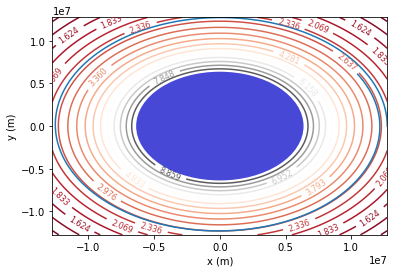

In [30]:
f_earth_local, f_earth_local_mag = compute_force_grid(xx_earth, yy_earth, earth)
fig, ax = plt.subplots()
plot_force_grid(xx_earth, yy_earth, f_earth_local_mag, [earth], fill=False, f_max=9.81)
plt.plot(sol.y[0], sol.y[1]);

Maximum relative error = -0.043831149174930806


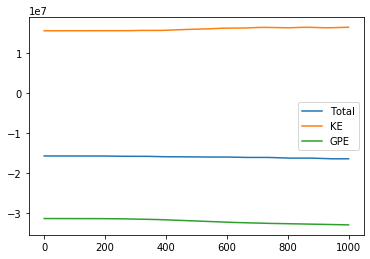

In [31]:
# Measure energy - Should be conserved in simulation
xs = sol.y[:2].T.reshape(-1, 2)
vs = sol.y[2:].T.reshape(-1, 2)
body_energy = [total_energy(x, v) for x, v in zip(xs, vs)]
body_ke = [kinetic_energy(v) for v in vs]
body_gpe = [potential_energy(x) for x in xs]
plt.plot(body_energy)
plt.plot(body_ke)
plt.plot(body_gpe)
plt.legend(['Total', 'KE', 'GPE']);

max_rel_error = 1 - (min(body_energy) - (max(body_energy) - min(body_energy)))/min(body_energy)
print(f'Maximum relative error = {max_rel_error}')

Can see that the orbit is not closed and energy is not conversed in the system -> numerical error is too large

### Simulation with high precision

In [32]:
sol = solve_ivp(orbit, tspan, Y0, events=hit_ground, t_eval=time, rtol=1e-9)

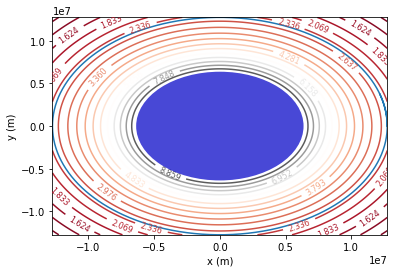

In [33]:
f_earth_local, f_earth_local_mag = compute_force_grid(xx_earth, yy_earth, earth)
fig, ax = plt.subplots()
plot_force_grid(xx_earth, yy_earth, f_earth_local_mag, [earth], fill=False, f_max=9.81)
plt.plot(sol.y[0], sol.y[1]);

Maximum relative error = -1.9501784631614782e-09


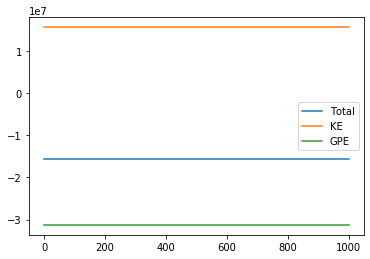

In [34]:
# Measure energy - Should be conserved in simulation
xs = sol.y[:2].T.reshape(-1, 2)
vs = sol.y[2:].T.reshape(-1, 2)
body_energy = [total_energy(x, v) for x, v in zip(xs, vs)]
body_ke = [kinetic_energy(v) for v in vs]
body_gpe = [potential_energy(x) for x in xs]
plt.plot(body_energy)
plt.plot(body_ke)
plt.plot(body_gpe)
plt.legend(['Total', 'KE', 'GPE']);

max_rel_error = 1 - (min(body_energy) - (max(body_energy) - min(body_energy)))/min(body_energy)
print(f'Maximum relative error = {max_rel_error}')

Orbit is closed and energy is conserved.

### Simulation of freefall

In [35]:
Y0 = [2 * earth.radius, 0, 0, 0] # Initial parameters
sol = solve_ivp(orbit, tspan, Y0, events=hit_ground, t_eval=time, rtol=1e-9)

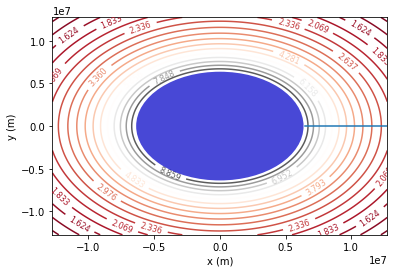

In [36]:
f_earth_local, f_earth_local_mag = compute_force_grid(xx_earth, yy_earth, earth)
fig, ax = plt.subplots()
plot_force_grid(xx_earth, yy_earth, f_earth_local_mag, [earth], fill=False, f_max=9.81)
plt.plot(sol.y[0], sol.y[1]);

Maximum relative error = -1.2818066830178054e-08


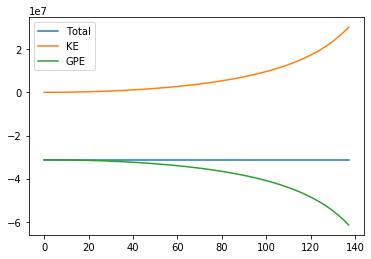

In [37]:
# Measure energy - Should be conserved in simulation
xs = sol.y[:2].T.reshape(-1, 2)
vs = sol.y[2:].T.reshape(-1, 2)
body_energy = [total_energy(x, v) for x, v in zip(xs, vs)]
body_ke = [kinetic_energy(v) for v in vs]
body_gpe = [potential_energy(x) for x in xs]
plt.plot(body_energy)
plt.plot(body_ke)
plt.plot(body_gpe)
plt.legend(['Total', 'KE', 'GPE']);

max_rel_error = 1 - (min(body_energy) - (max(body_energy) - min(body_energy)))/min(body_energy)
print(f'Maximum relative error = {max_rel_error}')

### Moonshot test

In [38]:
# Simulate gravitational orbit
def orbit(t, Y):
    """Y vector = (x, y, v_x, v_y)"""
    x = np.array(Y[:2])
    v = np.array(Y[2:])
    f_earth = f_grav(earth.mass, 1, earth.x, x, r_limit=earth.radius)
    f_moon = f_grav(moon.mass, 1, moon.x, x, r_limit=moon.radius)
    a = f_earth + f_moon
   
    # Update displacements with velocity of last step
    dx_dt = v[0]
    dy_dt = v[1]
    
    # Update velocity with velocity of last step and current acceleration, assume mass = 1
    dvx_dt = a[0]
    dvy_dt = a[1]
    
    return [dx_dt, dy_dt, dvx_dt, dvy_dt]

def hit_ground(t, y): 
    return y[0]*y[0] + y[1]*y[1] - earth.radius*earth.radius


tend = 2000000
time = np.linspace(0, tend, 1000) # Times to keep results
tspan = (0, tend) # Time inteval of integration

Y0 = [2 * earth.radius, 0, 7.8e3, 100] # Initial parameters

from scipy.integrate import solve_ivp
hit_ground.terminal = True


In [39]:
sol = solve_ivp(orbit, tspan, Y0, events=hit_ground, t_eval=time, rtol=1e-12, atol=1e-12, max_step=1e3)

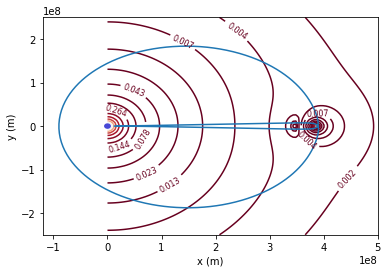

In [40]:
fig, ax = plt.subplots()
plot_force_grid(xx_system, yy_system, f_system_mag, [earth, moon], n_contours=20, f_max=9.81)
plt.plot(sol.y[0], sol.y[1]);

Maximum relative error = -1.7073164424233376


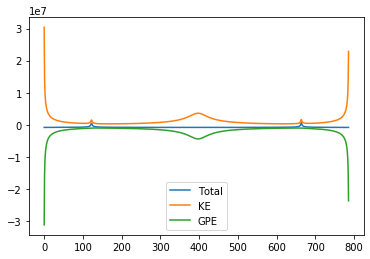

In [41]:
# Measure energy - Should be conserved in simulation
xs = sol.y[:2].T.reshape(-1, 2)
vs = sol.y[2:].T.reshape(-1, 2)
body_energy = [total_energy(x, v) for x, v in zip(xs, vs)]
body_ke = [kinetic_energy(v) for v in vs]
body_gpe = [potential_energy(x) for x in xs]
plt.plot(body_energy)
plt.plot(body_ke)
plt.plot(body_gpe)
#plt.yscale('log')
plt.legend(['Total', 'KE', 'GPE']);

max_rel_error = 1 - (min(body_energy) - (max(body_energy) - min(body_energy)))/min(body_energy)
print(f'Maximum relative error = {max_rel_error}')

Energy is mostly conserved during simulation, small blip from moon ~250.

In [42]:
%mprun sol = solve_ivp(orbit, tspan, Y0, events=hit_ground, t_eval=time, rtol=1e-12, atol=1e-12, max_step=1e3)

UsageError: Line magic function `%mprun` not found.


In [ ]:
body_energy[0], body_energy[-1]